In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install mahotas
import mahotas
import cv2
from skimage import util

def remove_background(image_path):
    # Load the image
    img = mahotas.imread(image_path)

    # Check if the image has three channels
    if len(img.shape) == 3 and img.shape[-1] == 3:
        # Convert to grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # If the image has more than two dimensions, take the first channel
    if len(img.shape) > 2:
        img = img[:, :, 0]

    # Perform Otsu thresholding to separate foreground and background
    T_otsu = mahotas.otsu(img)
    thresholded_img = img > T_otsu

    # Create a mask to keep the foreground in grayscale and set the background to white
    grayscale_img = img.copy()
    grayscale_img[thresholded_img] = 255  # Set foreground to white

    # Resize the image and add a single channel
    resized_img = cv2.resize(grayscale_img, (220, 155))
    resized_img = resized_img.reshape(resized_img.shape + (1,))

    return util.img_as_float(resized_img)


# Example usage:
# image_path = "/content/org_1.png"
# result_image = remove_background(image_path)
# print(result_image.shape)


In [ ]:
import zipfile
import os

def extract_zip_file(zip_file_path, extract_path):
    # Check if the zip file exists
    if not os.path.exists(zip_file_path):
        print(f"Error: Zip file '{zip_file_path}' not found.")
        return

    # Check if the extraction path exists, if not create it
    if not os.path.exists(extract_path):
        os.makedirs(extract_path)

    try:
        # Extract the contents of the zip file
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print(f"Successfully extracted '{zip_file_path}' to '{extract_path}'.")
    except Exception as e:
        print(f"Error: Failed to extract '{zip_file_path}'. {e}")

# Example usage
zip_file_path = '/content/drive/MyDrive/CEDAR_SIG.zip'
extract_path = '/content/dataset'
extract_zip_file(zip_file_path, extract_path)


Successfully extracted '/content/drive/MyDrive/CEDAR_SIG.zip' to '/content/dataset'.


In [ ]:
# PATH_ORG = "/content/dataset/CEDAR_SIG/full_org"
# PATH_FORG = "/content/dataset/CEDAR_SIG/full_forg"
PATH_ORG = "/content/dataset/CEDAR_SIG/full_forg"
PATH_FORG = "/content/dataset/CEDAR_SIG/full_org"

In [ ]:
import os
from natsort import natsorted, ns

def get_image_list():
  org_signs = os.listdir(PATH_ORG)
  forg_signs = os.listdir(PATH_FORG)
  org_signs = [s for s in org_signs if s.endswith(".png")]
  forg_signs = [s for s in forg_signs if s.endswith(".png")]
  org_signs = natsorted(org_signs, alg=ns.IGNORECASE)
  forg_signs = natsorted(forg_signs, alg=ns.IGNORECASE)
  return org_signs, forg_signs

# data cleaning
def check_lists(org_signs,forg_signs):
  flag = False
  for i in range(len(org_signs)):
    org_ext = org_signs[i][8:]
    forg_ext = forg_signs[i][9:]
    if org_ext != forg_ext:
      flag = True
      #print(i,org_ext,forg_ext)
  '''if(flag):
    #print("Mismatches found")
  else:
    #print("No mismatch found")
'''
def refine_lists(org_signs,forg_signs):
  refined_org_signs = []
  for i in range(len(org_signs)):
    if "_41_" in org_signs[i]:
      continue
    refined_org_signs.append(org_signs[i])

  refined_forg_signs = []
  for i in range(len(forg_signs)):
    if "_41_" in forg_signs[i]:
      continue
    refined_forg_signs.append(forg_signs[i])
  return refined_org_signs, refined_forg_signs

def get_clean_lists():
  org_signs, forg_signs = get_image_list()
  check_lists(org_signs,forg_signs)
  org_signs, forg_signs = refine_lists(org_signs,forg_signs)
  #print(len(org_signs),len(forg_signs))
  check_lists(org_signs,forg_signs)
  return org_signs, forg_signs

import random
import pandas as pd
import numpy as np

def get_dataframe(org_signs,forg_signs):
  no_of_ppl = len(org_signs)//24

  raw_data = {"image_1":[], "image_2":[], "label":[]}
  for i in range(no_of_ppl):
    i1_batch_1 = []
    i1_batch_2 = []
    i2_batch = []

    start = i*24
    end = (i+1)*24

    for j in range(start,end):
      i1_batch_1.append(os.path.join(PATH_ORG,org_signs[j]))
      i1_batch_2.append(os.path.join(PATH_ORG,org_signs[j]))
      raw_data["label"].append(1)#0

    temp_rot = (i1_batch_1[-12:]+i1_batch_1[:-12])
    i1_batch_1.extend(i1_batch_2)

    for elem in temp_rot:
      i2_batch.append(elem)

    for j in range(start,end):
      i2_batch.append(os.path.join(PATH_FORG,forg_signs[j]))
      raw_data["label"].append(0)#1

    raw_data["image_1"].extend(i1_batch_1)
    raw_data["image_2"].extend(i2_batch)
  df = pd.DataFrame(raw_data, columns = ["image_1","image_2","label"])
  df=df.reindex(np.random.permutation(df.index))
  return df

from sklearn.model_selection import train_test_split

def get_dataset(subset=None):
  org_signs,forg_signs = get_clean_lists()
  df = get_dataframe(org_signs,forg_signs)
  #print(df.shape)
  train_set, val_set = train_test_split(df,test_size=0.3,random_state=0)
  if(subset.lower()=="train"):
    dataset = train_set
  else:
    dataset = val_set
  return dataset

In [ ]:

import numpy as np
import keras
from PIL import Image
import cv2

class DataGenerator(keras.utils.Sequence):

    def __init__(self, df, batch_size=32, dim=(155,220), n_channels=3, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.labels = df["label"]
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        rows = [self.df.iloc[k] for k in indexes]
        X, y = self.__data_generation(rows)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(self.df.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, rows):
        x_1 = np.empty((self.batch_size, *self.dim, self.n_channels))
        x_2 = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        for i in range(len(rows)):
            image_1 = cv2.imread(rows[i]["image_1"])
            image_1 = cv2.resize(image_1,(220,155))
            image_1 = cv2.bitwise_not(image_1)
            image_1=np.array(image_1)
            image_2 = cv2.imread(rows[i]["image_2"])
            image_2 = cv2.resize(image_2,(220,155))
            image_2 = cv2.bitwise_not(image_2)
            image_2=np.array(image_2)
            '''mean_center_1 = image_1 - np.mean(image_1, axis = None)
            mean_center_2 = image_2 - np.mean(image_2, axis = None)

            std_1 = np.std(image_1)
            std_2 = np.std(image_2)
            if(std_1 == 0 or std_1 == np.nan):
                std_1 = 1
            if(std_2 == 0 or std_2 == np.nan):
                std_2 = 1
            standardized_img_1 = image_1/std_1
            standardized_img_2 = image_2/std_2
            '''
            x_1[i,] = image_1/255
            x_2[i,] = image_2/255
            y[i] = rows[i]["label"]


        return [x_1, x_2], y

In [ ]:

from keras import models
from keras.layers import Conv2D, MaxPooling2D, Dense, Activation, BatchNormalization, Input, Dropout, Flatten
from keras.models import Model

def get_base_net():
  input = Input(shape=(155,220,3))

  conv_1 = Conv2D(filters=96, kernel_size=(11,11))(input)
  batch_norm_1 = BatchNormalization()(conv_1)
  activation_1 = Activation('relu')(batch_norm_1)
  max_pool_1 = MaxPooling2D(pool_size=(3,3))(activation_1)

  conv_2 = Conv2D(filters=256, kernel_size=(5,5))(max_pool_1)
  batch_norm_2 = BatchNormalization()(conv_2)
  activation_2 = Activation('relu')(batch_norm_2)
  max_pool_2 = MaxPooling2D(pool_size=(3,3))(activation_1)

  dropout_1 = Dropout(rate=0.3)(max_pool_2)

  conv_3_a = Conv2D(filters=384, kernel_size=(3,3))(dropout_1)
  activation_3_a = Activation('relu')(conv_3_a)
  conv_3_b = Conv2D(filters=256, kernel_size=(3,3))(activation_3_a)
  activation_3_b = Activation('relu')(conv_3_b)
  max_pool_3 = MaxPooling2D(pool_size=(3,3))(activation_3_b)

  dropout_2 = Dropout(rate=0.3)(max_pool_3)

  flat_1 = Flatten()(dropout_2)
  fc_1 = Dense(units=1024,activation='relu')(flat_1)
  dropout_3 = Dropout(rate=0.5)(fc_1)
  fc_2 = Dense(units=128,activation='relu')(dropout_3)
  return Model(input,fc_2)

In [ ]:
from keras import backend as K

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


In [ ]:
import tensorflow as tf
def contrastive_loss(y_true, y_pred):
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    y_true = tf.cast(y_true, tf.float32)

    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)

def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [ ]:
from keras.layers import Lambda

input_a = Input(shape=(155,220,3))
input_b = Input(shape=(155,220,3))

base_net = get_base_net()
processed_a = base_net(input_a)
processed_b = base_net(input_b)

distance = Lambda(euclidean_distance,output_shape=eucl_dist_output_shape)([processed_a, processed_b])
model = Model([input_a, input_b], distance)

In [ ]:
from keras import optimizers
optimizer = optimizers.RMSprop()
model.compile(loss=contrastive_loss, optimizer=optimizer, metrics=[accuracy])

In [ ]:
params={
    'dim': (155,220),
    'batch_size': 32,
    'n_channels': 3,
    'shuffle': False
}

#train_set = 2592*0.7 = 1814 == 1814/32 == 56
#val_set = 2592*0.3 = 777 == 777/32 == 24
ds_train = get_dataset("train")
ds_val = get_dataset("val")
train_datagen = DataGenerator(ds_train,**params)
validation_datagen = DataGenerator(ds_val,**params)
# Iterate through the DataGenerator
# for data in train_datagen:
#     # Process each data item in the generator
#     print('....')
#     print(np.array(data).shape)
hist = model.fit_generator(generator=train_datagen, validation_data=validation_datagen, epochs=80, steps_per_epoch=56, validation_steps=24, use_multiprocessing=True, workers=1)

<ipython-input-12-6c201fc8ee21>:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(generator=train_datagen, validation_data=validation_datagen, epochs=80, steps_per_epoch=56, validation_steps=24, use_multiprocessing=True, workers=1)


Epoch 1/80
56/56 [==============================] - 106s 2s/step - loss: 81.6317 - accuracy: 0.6942 - val_loss: 0.1298 - val_accuracy: 0.7682
Epoch 2/80
56/56 [==============================] - 128s 2s/step - loss: 0.1323 - accuracy: 0.8438 - val_loss: 9.3317e-06 - val_accuracy: 1.0000
Epoch 3/80
56/56 [==============================] - 92s 2s/step - loss: 0.3763 - accuracy: 0.7461 - val_loss: 0.0088 - val_accuracy: 1.0000
Epoch 4/80
56/56 [==============================] - 115s 2s/step - loss: 0.1471 - accuracy: 0.8878 - val_loss: 0.0960 - val_accuracy: 0.8711
Epoch 5/80
56/56 [==============================] - 113s 2s/step - loss: 0.1198 - accuracy: 0.9314 - val_loss: 0.0025 - val_accuracy: 0.9987
Epoch 6/80
56/56 [==============================] - 110s 2s/step - loss: 0.0413 - accuracy: 0.9621 - val_loss: 0.3312 - val_accuracy: 0.5195
Epoch 7/80
56/56 [==============================] - 117s 2s/step - loss: 0.0471 - accuracy: 0.9565 - val_loss: 0.0029 - val_accuracy: 0.9961
Epoch 8/8

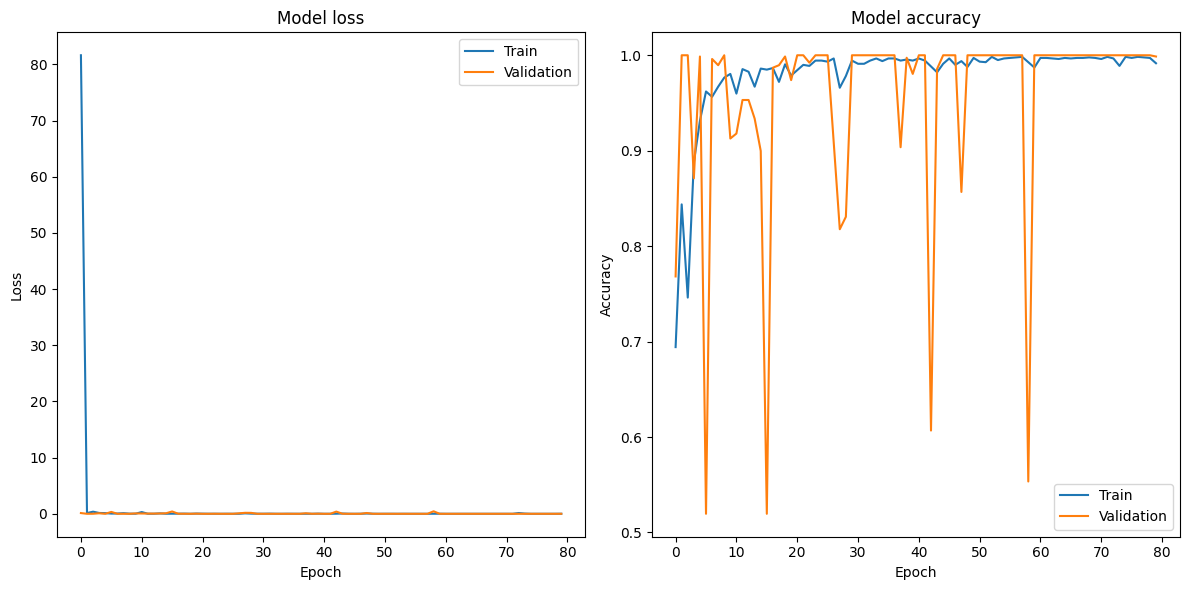

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is your history object
# history = model.fit(...)
history = hist
# Plot training & validation loss values
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
# Plot validation loss
plt.plot(history.history['val_loss'], label='Validation')

plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')

plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
'''
last step of training :    xfvfdgdfg
Epoch 30/30
56/56 [==============================] - 61s 1s/step - loss: 0.3110 - accuracy: 0.8142 - val_loss: 0.0254 - val_accuracy: 0.9753
<keras.callbacks.History at 0x7f4ccc806eb8>
'''
model.save("drive/My Drive/Colab Notebooks/SigNet/colab_08072019.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model

mod = load_model('./drive/My Drive/Colab Notebooks/SigNet/colab_08072019.h5',custom_objects={'contrastive_loss':contrastive_loss})

In [ ]:
img = remove_background('/content/forgeries_6_21.png')
img.shape

FileNotFoundError: [Errno 2] No such file or directory: '/content/forgeries_6_21.png'

In [ ]:

# data = img
# print('Shape of Input data :',data.shape)

# # Perform dictionary learning
# n_components = 100 # Number of dictionary atoms to learn
# dl = MiniBatchDictionaryLearning(n_components=n_components,
# 								alpha=1.0,
# 								n_iter=500)
# # training
# dl.fit(data)

# # Denoise the patches using the learned dictionary
# denoised_patches = np.dot(dl.transform(data), dl.components_)
# print('Shape of Output Denoised patches:',denoised_patches.shape)

# # Show the original noisy image and the denoised image
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.imshow(data,cmap='gray')
# plt.title('Noisy Image')
# plt.axis('off')
# plt.subplot(1, 2, 2)
# plt.imshow(denoised_patches,cmap='gray')
# plt.title('Denoised Image')
# plt.axis('off')
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np


# def show_image_difference(image1, image2, title1='Image 1', title2='Image 2'):
#     """
#     Display the difference between two images side by side.

#     Parameters:
#     - image1: First input image.
#     - image2: Second input image.
#     - title1: Title for the first image (default: 'Image 1').
#     - title2: Title for the second image (default: 'Image 2').
#     """
#     # Ensure images have the same shape
#     if image1.shape != image2.shape:
#         raise ValueError("Input images must have the same shape.")

#     # Create a figure with two subplots
#     fig, axs = plt.subplots(1, 2, figsize=(10, 5))

#     # Plot the first image
#     axs[0].imshow(image1, cmap='gray')
#     axs[0].set_title(title1)
#     axs[0].axis('off')

#     # Plot the second image
#     axs[1].imshow(image2, cmap='gray')
#     axs[1].set_title(title2)
#     axs[1].axis('off')

#     # Show the difference image
#     diff_image = np.abs(image1 - image2)
#     fig_diff, ax_diff = plt.subplots(figsize=(5, 5))
#     ax_diff.imshow(diff_image, cmap='viridis')
#     ax_diff.set_title('Absolute Difference')
#     ax_diff.axis('off')

#     # Show the plots
#     plt.show()

# # Example usage:
# # Assuming you have two images represented as 2D numpy arrays called 'image1' and 'image2'
# # show_image_difference(image1, image2, title1='Original Image', title2='Modified Image')
# # non_adv = mahotas.imread('/content/forgeries_1_1.png')
# non_adv = remove_background('/content/original_6_21.png')
# show_image_difference(adv, non_adv, title1='Adversarial', title2='Non-adversarial')

In [ ]:
# def remove_background(image_path):
#     # Load the image
#     img = mahotas.imread(image_path)

#     # Perform Otsu thresholding to separate foreground and background
#     T_otsu = mahotas.otsu(img)
#     thresholded_img = img > T_otsu

#     # Create a mask to keep the foreground in grayscale and set the background to white
#     grayscale_img = img.copy()
#     grayscale_img[thresholded_img] = 255  # Set foreground to whit

#     return grayscale_img.astype(np.uint8)

### Forgerie and Original

In [ ]:

from skimage import io, transform

import cv2
import numpy as np
import matplotlib.pyplot as plt


# # Load the images
im_1 = cv2.imread(f'/content/dataset/CEDAR_SIG/full_forg/forgeries_10_{2}.png')
im_2 = cv2.imread(f'/content/dataset/CEDAR_SIG/full_org/original_10_{1}.png')
# im_1 = remove_background('/content/forgeries_6_21.png')
# im_2 = remove_background('/content/original_6_21.png')
# Convert the image to gray scale image
# img_1 = cv2.cvtColor(im_1, cv2.COLOR_BGR2GRAY);
# Resize the images
print(im_1.shape)
im_1 = cv2.resize(im_1, (220, 155))
im_2 = cv2.resize(im_2, (220, 155))

# Invert the colors and normalize
im_1 = cv2.bitwise_not(im_1)
im_2 = cv2.bitwise_not(im_2)
im_1 = im_1 / 255.0
im_2 = im_2 / 255.0

# Expand dimensions for model input
im_1 = np.expand_dims(im_1, axis=0)
im_2 = np.expand_dims(im_2, axis=0)


# Create a figure with two subplots
fig, axes = plt.subplots(1, 2)

# Display the first image
axes[0].imshow(im_1[0], cmap='gray')
axes[0].set_title("Pat # (Generated Original)")  # Set the label for img 1
axes[0].axis('off')  # Turn off axis labels

# Display the second image
axes[1].imshow(im_2[0], cmap='gray')
axes[1].set_title("Pat # (Non-generated Forged)")  # Set the label for img 2
axes[1].axis('off')  # Turn off axis labels

# Show the plot
plt.show()

print(im_1.shape,im_2.shape)
y_pred = model.predict([im_1,im_2])

In [ ]:
y_pred

#### Original and different variation of Original

In [ ]:

from skimage import io, transform

import cv2
import numpy as np
import matplotlib.pyplot as plt


# # Load the images
# im_1 = cv2.imread(f'/content/dataset/CEDAR_SIG/full_org/original_10_{3}.png')
# im_2 = cv2.imread(f'/content/dataset/CEDAR_SIG/full_org/original_10_{1}.png')
im_1 = remove_background(f'/content/dataset/CEDAR_SIG/full_org/original_10_{3}.png')
im_2 = remove_background(f'/content/dataset/CEDAR_SIG/full_org/original_10_{1}.png')
# Convert the image to gray scale image
# img_1 = cv2.cvtColor(im_1, cv2.COLOR_BGR2GRAY);
# Resize the images
print(im_1.shape)
im_1 = cv2.resize(im_1, (220, 155))
im_2 = cv2.resize(im_2, (220, 155))

# Invert the colors and normalize
im_1 = cv2.bitwise_not(im_1)
im_2 = cv2.bitwise_not(im_2)
im_1 = im_1 / 255.0
im_2 = im_2 / 255.0

# Expand dimensions for model input
im_1 = np.expand_dims(im_1, axis=0)
im_2 = np.expand_dims(im_2, axis=0)


# Create a figure with two subplots
fig, axes = plt.subplots(1, 2)

# Display the first image
axes[0].imshow(im_1[0], cmap='gray')
axes[0].set_title("Pat # (Generated Original)")  # Set the label for img 1
axes[0].axis('off')  # Turn off axis labels

# Display the second image
axes[1].imshow(im_2[0], cmap='gray')
axes[1].set_title("Pat # (Non-generated Forged)")  # Set the label for img 2
axes[1].axis('off')  # Turn off axis labels

# Show the plot
plt.show()

print(im_1.shape,im_2.shape)
y_pred = model.predict([im_1,im_2])
y_pred

In [ ]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

total = 0
pos = 0
for i in range(40):
  for v in range(12):

    # Load the images
    im_1 = cv2.imread(f'/content/dataset/CEDAR_SIG/full_org/original_{i+1}_{v+1}.png')
    im_2 = cv2.imread(f'/content/dataset/CEDAR_SIG/full_forg/forgeries_{i+1}_{v+2}.png')

    # Resize the images
    im_1 = cv2.resize(im_1, (220, 155))
    im_2 = cv2.resize(im_2, (220, 155))

    # Invert the colors and normalize
    im_1 = cv2.bitwise_not(im_1)
    im_2 = cv2.bitwise_not(im_2)
    im_1 = im_1 / 255.0
    im_2 = im_2 / 255.0
    # Expand dimensions for model input
    im_1 = np.expand_dims(im_1, axis=0)
    im_2 = np.expand_dims(im_2, axis=0)

    y_pred = model.predict([im_1,im_2])
    total+=1
    print(y_pred[0][0])
    if y_pred[0][0]>=0.5:
      pos+=1

print(f'Accuracy {(pos/total)*100}%')


### Test On Generated Image

In [ ]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the images
im_1 = cv2.imread("/content/original/original_33_3.png")
im_2 = cv2.imread("/content/Generated/original_33_3.png")
# im_2 = cv2.imread("/content/dataset/CEDAR_SIG/full_org/original_33_3.png")

# im_2 = cv2.imread("/content/dataset/CEDAR_SIG/full_org/original_24_19.png")
# Resize the images
im_1 = cv2.resize(im_1, (220, 155))
im_2 = cv2.resize(im_2, (220, 155))
print(im_2.shape, im_1.shape)

# Invert the colors and normalize
im_1 = cv2.bitwise_not(im_1)
im_2 = cv2.bitwise_not(im_2)
im_1 = im_1 / 255.0
im_2 = im_2 / 255.0

# Expand dimensions for model input
im_1 = np.expand_dims(im_1, axis=0)
im_2 = np.expand_dims(im_2, axis=0)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2)

# Display the first image
axes[0].imshow(im_1[0], cmap='gray')
axes[0].set_title("Pat # (Generated Original)")  # Set the label for img 1
axes[0].axis('off')  # Turn off axis labels

# Display the second image
axes[1].imshow(im_2[0], cmap='gray')
axes[1].set_title("Pat # (Non-Generated Original)")  # Set the label for img 2
axes[1].axis('off')  # Turn off axis labels

# Show the plot
plt.show()

y_pred = model.predict([im_1,im_2])

In [ ]:
y_pred

#### Dictionary Learning adversarial perturbation

In [ ]:
import os
import cv2
import numpy as np
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction import image
import matplotlib.pyplot as plt

img = cv2.imread('/content/original/original_33_3.png', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (220,155))
img = cv2.bitwise_not(img)

noisy_image = img
print('Noise Image shape:',noisy_image.shape)

# Extract small patches from the grayscale image
patch_size = (3, 3)
patches = image.extract_patches_2d(noisy_image, patch_size)
print('Number of Patches :',patches.shape[0])
print('Shape of patches:',patches.shape)
# Reshape the patches for dictionary learning
data = patches.reshape(patches.shape[0], -1)
print('Shape of Input data :',data.shape)

# Perform dictionary learning
n_components = 100 # Number of dictionary atoms to learn
dl = MiniBatchDictionaryLearning(n_components=n_components,
								alpha=0.004,
								n_iter=50)
# training
dl.fit(data)

# Denoise the patches using the learned dictionary
denoised_patches = np.dot(dl.transform(data), dl.components_)
print('Shape of Output Denoised patches:',denoised_patches.shape)

# Reshape the denoised patches back to their original shape
denoised_patches = denoised_patches.reshape(patches.shape)

# Reconstruct the denoised image from the patches
reconstructed_image = image.reconstruct_from_patches_2d(denoised_patches, noisy_image.shape)
data = img

# Perform dictionary learning
n_components = 100 # Number of dictionary atoms to learn
dl = MiniBatchDictionaryLearning(n_components=n_components,
								alpha=1.0,
								n_iter=500)
# training
dl.fit(data)

# Denoise the patches using the learned dictionary
denoised_patches = np.dot(dl.transform(data), dl.components_)


adv = data  * (0.000001*denoised_patches)
y_pred = model.predict([adv,img])
y_pred

### Test On All Generated Images

In [ ]:
zip_file_path = '/content/Generated Images.zip'
extract_path = '/content/generated1_dataset'
extract_zip_file(zip_file_path, extract_path)

In [ ]:
import os

def print_image_names_colab(folder_path):
    # List files in the specified folder
    files = os.listdir(folder_path)

    # Filter out only image files (you can customize the list of supported extensions)
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
    image_files = [file for file in files if any(file.lower().endswith(ext) for ext in image_extensions)]
    total = 0
    pos = 0
    # Print the names of the image files
    if not image_files:
        print(f"No image files found in the folder '{folder_path}'.")
    else:
        print("Image files in the folder:")
        for image_file in image_files:
            # print(image_file)

            # Load the images
            im_1 = cv2.imread(f'/content/original/{image_file}')
            im_2 = cv2.imread(f'/content/Generated/{image_file}')

            # Resize the images
            im_1 = cv2.resize(im_1, (220, 155))
            im_2 = cv2.resize(im_2, (220, 155))

            # Invert the colors and normalize
            im_1 = cv2.bitwise_not(im_1)
            im_2 = cv2.bitwise_not(im_2)
            im_1 = im_1 / 255.0
            im_2 = im_2 / 255.0
            # Expand dimensions for model input
            im_1 = np.expand_dims(im_1, axis=0)
            im_2 = np.expand_dims(im_2, axis=0)
            # Create a figure with two subplots
            fig, axes = plt.subplots(1, 2)

            # Display the first image
            axes[0].imshow(im_1[0], cmap='gray')
            axes[0].set_title("Pat # (Generated Original)")  # Set the label for img 1
            axes[0].axis('off')  # Turn off axis labels

            # Display the second image
            axes[1].imshow(im_2[0], cmap='gray')
            axes[1].set_title("Pat # (Non-Generated Original)")  # Set the label for img 2
            axes[1].axis('off')  # Turn off axis labels

            # Show the plot
            plt.show()

            y_pred = model.predict([im_1,im_2])
            total+=1
            print(y_pred[0][0])
            if y_pred[0][0]<=0.6:
              pos+=1
        print(f'Accuracy {(pos/total)*100}%')

# Example usage:
folder_path_colab = "/content/Generated"  # Change to the path of your folder in Colab
print_image_names_colab(folder_path_colab)


### Remove background of original dataset



In [ ]:
import os
import mahotas
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from PIL import Image
import cv2  # Add this import

import os
import mahotas
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from PIL import Image
import cv2  # Add this import

def remove_background_and_save(image_path, category,save_path="/content"):
    # Load the image
    img = mahotas.imread(image_path)

    # Perform Otsu thresholding to separate foreground and background
    T_otsu = mahotas.otsu(img)
    thresholded_img = img > T_otsu

    # Create a mask to keep the foreground in grayscale and set the background to white
    grayscale_img = img.copy()
    grayscale_img[thresholded_img] = 255  # Set foreground to white

    # Save the processed image in the "preprocessed" folder
    preprocessed_folder = os.path.join(save_path, category)
    os.makedirs(preprocessed_folder, exist_ok=True)  # Create the folder if it doesn't exist

    save_name = os.path.basename(image_path)
    save_name = os.path.splitext(save_name)[0] + ".png"
    save_path = os.path.join(preprocessed_folder, save_name)
    cv2.imwrite(save_path, grayscale_img)

    # # Plot the original and processed images side by side
    # fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # # Plot original image
    # axs[0].imshow(img, cmap='gray')
    # axs[0].set_title('Original Image')
    # axs[0].axis('off')

    # # Plot image after background removal
    # axs[1].imshow(grayscale_img, cmap='gray')
    # axs[1].set_title('After Background Removal')
    # axs[1].axis('off')

    # plt.show()

    return grayscale_img.astype(np.uint8)




In [ ]:
image_path = "/content/original_33_3_processed.png"
img = cv2.imread(image_path)
print(img.shape)

In [ ]:
import os

def save_removed_background_img(folder_path,signature_category):
    # List files in the specified folder
    files = os.listdir(folder_path)

    # Filter out only image files (you can customize the list of supported extensions)
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
    image_files = [file for file in files if any(file.lower().endswith(ext) for ext in image_extensions)]
    total = 0
    pos = 0
    # Print the names of the image files
    if not image_files:
        print(f"No image files found in the folder '{folder_path}'.")
    else:
        print("Image files in the folder:")
        for image_file in image_files:
          # Example usage
          save_name = image_file.split("_")
          save_name = f'{signature_category}_{save_name[1]}_{save_name[2].split(".")[0]}.png'
          image_path = f"/content/dataset/CEDAR_SIG/full_forg/{save_name}"
          result_img = remove_background_and_save(image_path,signature_category)



In [ ]:
name = 'original_32_3.png'

# Split the name by "-"
name_parts = name.split("_")

# Print the result
print(name_parts)


In [ ]:
import os

def print_image_names_colab(folder_path):
    # List files in the specified folder
    files = os.listdir(folder_path)

    # Filter out only image files (you can customize the list of supported extensions)
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
    image_files = [file for file in files if any(file.lower().endswith(ext) for ext in image_extensions)]
    total = 0
    pos = 0
    # Print the names of the image files
    if not image_files:
        print(f"No image files found in the folder '{folder_path}'.")
    else:
        print("Image files in the folder:")
        for image_file in image_files:
            # print(image_file)
            save_name = image_file.split("_")
            forgeries = f'forgeries_{save_name[1]}_{save_name[2].split(".")[0]}.png'
            original = f'original_{save_name[1]}_{save_name[2].split(".")[0]}.png'

            # Load the images
            im_1 = cv2.imread(f'/content/preprocessed/{original}')
            im_2 = cv2.imread(f'/content/forgery_preprocessed/{forgeries}')

            # Resize the images
            im_1 = cv2.resize(im_1, (220, 155))
            im_2 = cv2.resize(im_2, (220, 155))

            # Invert the colors and normalize
            im_1 = cv2.bitwise_not(im_1)
            im_2 = cv2.bitwise_not(im_2)
            im_1 = im_1 / 255.0
            im_2 = im_2 / 255.0
            # Expand dimensions for model input
            im_1 = np.expand_dims(im_1, axis=0)
            im_2 = np.expand_dims(im_2, axis=0)
            # Create a figure with two subplots
            fig, axes = plt.subplots(1, 2)

            # Display the first image
            axes[0].imshow(im_1[0], cmap='gray')
            axes[0].set_title("Pat # (Generated Original)")  # Set the label for img 1
            axes[0].axis('off')  # Turn off axis labels

            # Display the second image
            axes[1].imshow(im_2[0], cmap='gray')
            axes[1].set_title("Pat # (Non-Generated Original)")  # Set the label for img 2
            axes[1].axis('off')  # Turn off axis labels

            # Show the plot
            plt.show()

            y_pred = model.predict([im_1,im_2])
            total+=1
            print(y_pred[0][0])
            if y_pred[0][0]>=0.6:
              pos+=1
        print(f'Accuracy {(pos/total)*100}%')

# Example usage:
folder_path_colab = "/content/generated1_dataset/Generated Images"  # Change to the path of your folder in Colab
print_image_names_colab(folder_path_colab)


#### GENERATE NEW DATASET WITHOUT BACKGROUND

In [ ]:
import numpy as np
folder_path_colab = "/content/dataset/CEDAR_SIG/full_forg"  # Change to the path of your folder in Colab
save_removed_background_img(folder_path_colab,'forgeries')